In [1]:
import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import matplotlib.patches  as patches
import matplotlib.gridspec as gridspec

from scipy                   import optimize
from scipy.integrate         import quad
from scipy.optimize          import minimize
from scipy.optimize          import BFGS
from scipy.optimize          import Bounds
from scipy.optimize          import NonlinearConstraint
from scipy.optimize.nonlin   import NoConvergence

In [2]:
#typo='Tlds'
#df = pd.HDFStore(f'../corrections_6206_{typo}.h5')['/edf']

#Emax, Emin = 430e3, 380e3
#edf = df[(df.e<Emax) & (df.e>Emin) & (df.peak==0)]
#E = np.array(edf['e'])
#E.sort()
#len(E)

In [3]:
#n = 10
#E = np.array([E[n*i] for i in range(0, int(len(E)/n))])
#len(E)

In [4]:
#plt.hist(E, bins=100);

## DATA PRODUCTION

$$f(E)= f f_s(E| E_{ph}, \sigma) + (1-f) f_b(E|m)$$


$$f_s(E|E_{ph},\sigma) = A(E_{ph}, \sigma) e^{-(E-E_{ph})^2/(2\sigma^2)}$$

$$f_b(E|m) = m(E-c) + r$$

$$c = \frac{E_a+E_b}{2}$$

$$r = \frac{1}{(E_b-E_a)}$$

$$m ~ [-2/(b-a)^2, 2/(b-a)^2] $$

In [2]:
def p(E):
    return f*ps(E)+ (1-f)*pb(E)

def ps(E):
    A,_ = quad(gauss, Ea, Eb, args=(Eph, sig))
    return gauss(E, Eph, sig)/A

def gauss(E, Eph, sig):
    return np.e**(-(E-Eph)**2/(2*sig**2))

def pb(E):
    return m*E + c(m)

def c(m):
    return (1-0.5*m*(Eb**2-Ea**2))/(Eb-Ea)

def P(E):
    Ps, _ = quad(ps, Ea, E)
    return f* Ps + (1-f)*0.5*m*(E**2-Ea**2) + (1-f)*c(m)*(E-Ea)

In [3]:
# REGION AND PARAMETERS DEFINITION

Ea, Eb = 380e3, 430e3
f, Eph, sig, m = 0.5, 400e3, 3e3, -0.5e-9

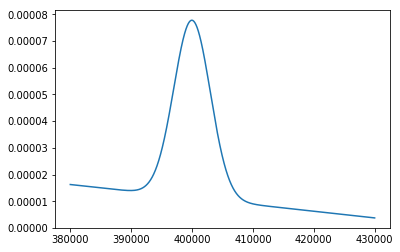

In [4]:
E =np.linspace(Ea, Eb, int(1e5))
plt.plot(E, p(E));

In [5]:
def rand_lin(a, b, m, size=100):
    '''returns random number linearly distributed'''
    E=[]
    i=0
    while i<size:
        F =np.random.random()
        #E1 = -c(m)/m + ((c(m)/m)**2+2/m*(F+a*(c(m)+0.5*m*a)))**0.5
        E2 = -c(m)/m - ((c(m)/m)**2+2/m*(F+a*(c(m)+0.5*m*a)))**0.5
        E.append(E2)
        i+=1
    E = np.array(E)
    return E

In [6]:
E = rand_lin(Ea, Eb, m, size=1000)
Emin, Emax = Ea, Eb

def likelihood(x):
    m = x
    p = fb(x)
    
    if (p>=0).all():
        return -np.log(p).sum()
    else: print(x)
    #    return np.inf

def jac_lik(x):
    m = x
    p = fb(x)
    mb         = jac_b(x)
    mder   = -(mb     /p).sum()
    return np.array([mder])

def fb(x):  
    m = x
    ct = c(m)
    return m*E + ct

def c(m):
    return (1-0.5*m*(Emax**2-Emin**2))/(Emax-Emin)

def jac_b(x):
    mder = E - 0.5*(Emax**2-Emin**2)/(Emax-Emin)
    return mder
########################################
########################################
#########################################
def fb_constr(x):
    m = x
    ct = c(m)
    return m*E + ct

def jac_b_constr(x):
    return np.array([E - 0.5*(Emax**2-Emin**2)/(Emax-Emin)]).T

def hess_constr(x, v):
    return 0


# trust-constr algorithm

lb = [-1]
ub = [ 1]

bounds = Bounds(lb, ub, keep_feasible=True)
x0     = np.array([1e-10])

ub_b = np.inf*np.ones(len(E))
lb_b = np.zeros(len(E))

constraints = [NonlinearConstraint(fb_constr, lb_b, ub_b, jac=jac_b_constr, hess=hess_constr, keep_feasible=True)]

res = minimize(likelihood, x0,
               method = 'trust-constr',
               options={'disp':True, 'verbose':3, 'maxiter':1000, 'initial_tr_radius':1,
                        'gtol':1e-8, 'xtol':1e-8, 'barrier_tol': 1e-8,
                        'initial_constr_penalty':1e-3, 'gtol':1e-8, 'xtol':1e-5},
               jac   = jac_lik,
               hess  = BFGS(),
               constraints=constraints,
               bounds=bounds)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +1.0852e+04 | 1.00e+00 | 6.10e-05 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +1.0838e+04 | 7.00e+00 | 6.10e-05 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   2   |
|   3   |   3   |   2   | +1.0766e+04 | 4.90e+01 | 3.05e-05 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   2   |
|   4   |   4   |   3   | +1.0737e+04 | 4.90e+01 | 2.10e-05 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   1   |
|   5   |   4   |   3   | +1.0737e+04 | 2.45e+02 | 1.91e-06 | 0.00e+00 | 1.00e-03 |  2.00e-02   |   0   |
|   6   |   5   |   4   | +1.0737e+04 | 2.45e+02 | 2.86e-06 | 0.00e+00 | 1.00e-03 |  2.00e-02   |   1   |
|   7   |   6   |   5   | +1.0737e+04 | 2.45e+02 | 7.57e-06 | 0.00e+00 | 1.00e-03 |  2.00e-02   |   1   |
|   8   |   6   |   5   | +1.0737e+04 | 1.22e+

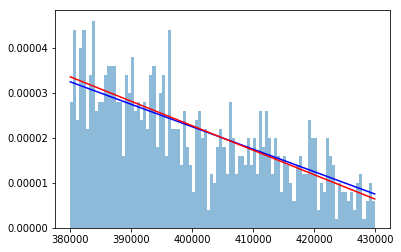

In [7]:
E.sort()
plt.hist(E, bins=100, density=True, alpha=0.5);
plt.plot(E, pb(E), c='b');
plt.plot(E, fb(res.x), c='r')

In [8]:
E = np.random.normal(Eph, sig, size=1000)

def likelihood(x):
    p = fs(x)
    
    if (p>=0).all():
        return -np.log(p).sum()
    else: print(x)
    #    return np.inf

def jac_lik(x):
    p = fs(x)
    
    Ephs, sigs = jac_s(x)

    Ephder = -(Ephs   /p).sum()
    sigder = -(sigs   /p).sum()
    return np.array([Ephder, sigder])

def fs(x):
    Eph, sig = x
    A, _ = quad(gauss, Emin, Emax, args=(Eph, sig))
    return (1/A)*gauss(E, Eph, sig)

def gauss(E, Eph, sig):
    return np.e**(-(E-Eph)**2/(2*sig**2))

def jac_s(x):
    Eph, sig= x
    
    Ephder = fs(x)*(E-Eph)/sig**2
    sigder = fs(x)*(-1/sig + (E-Eph)**2/sig**3)
    
    return np.array([Ephder, sigder])

###################################
##################################

# trust-constr algorithm

lb = [Emin, 0     ]
ub = [Emax, np.inf]

bounds = Bounds(lb, ub, keep_feasible=True)
x0     = np.array([402e3, 2e3])

ub_b = np.inf*np.ones(len(E))
lb_b = np.zeros(len(E))

constraints = [NonlinearConstraint(fs, lb_b, ub_b, keep_feasible=True)]

res = minimize(likelihood, x0,
               method = 'trust-constr',
               options={'disp':True, 'verbose':3, 'maxiter':10000, 'initial_tr_radius':1,
                        'gtol':1e-8, 'xtol':1e-8, 'barrier_tol': 1e-8,
                        'initial_constr_penalty':1e-3, 'gtol':1e-8, 'xtol':1e-5},
               jac   = jac_lik,
               hess  = BFGS(),
               constraints=constraints,
               bounds=bounds)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +1.0161e+04 | 1.00e+00 | 1.25e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +1.0160e+04 | 4.82e+00 | 1.25e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   4   |
|   3   |   3   |   2   | +1.0154e+04 | 3.37e+01 | 1.23e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   2   |
|   4   |   4   |   3   | +1.0114e+04 | 2.36e+02 | 1.16e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   2   |
|   5   |   5   |   4   | +9.8901e+03 | 1.65e+03 | 7.34e-01 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   2   |
|   6   |   6   |   6   | +9.6756e+03 | 2.63e+03 | 3.52e-01 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   1   |
|   7   |   7   |   7   | +9.5717e+03 | 2.63e+03 | 2.07e-01 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   4   |
|   8   |   8   |   9   | +9.5189e+03 | 2.63e+

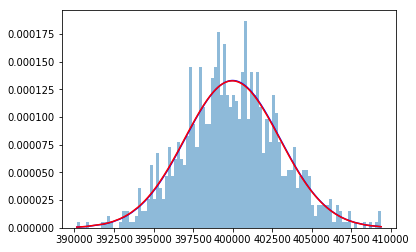

In [9]:
E.sort()
plt.hist(E, bins=100, density=True, alpha=0.5);
plt.plot(E, ps(E), c='b');
plt.plot(E, fs(res.x), c='r')

In [11]:
n=1e4

Ebk = rand_lin(Ea, Eb, m, size=(1-f)*n)
Esg = np.random.normal(Eph, sig, size=int(f*n))

E=np.array([*Ebk, *Esg])
E.sort()

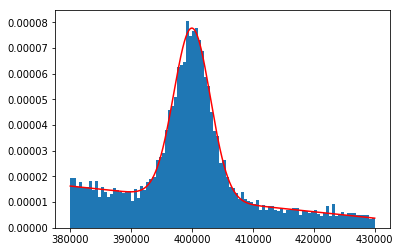

In [12]:
plt.hist(E, bins=100, density=True);
x = [f, Eph, sig, m]
plt.plot(E, f*ps(E)+(1-f)*pb(E), c='r');

In [13]:
len(E)

10000

In [14]:
n = 10
E = np.array([E[n*i] for i in range(0, int(len(E)/n))])
len(E)

1000

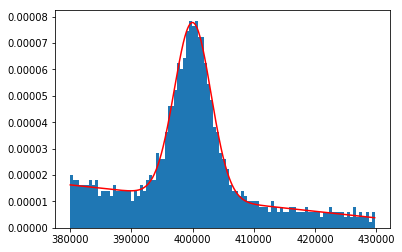

In [15]:
E.sort()
plt.hist(E, bins=100, density=True);
x = [f, Eph, sig, m]
plt.plot(E, f*ps(E)+(1-f)*pb(E), c='r');

In [16]:
Emin, Emax = Ea, Eb

## EXTENDED LIKELIHOOD METHOD

In [17]:
def likelihood(x):
    f = x[0]
    p = f*fs(x) + (1-f)*fb(x)
    
    if (p>=0).all():
        return -np.log(p).sum()
    else: print(x)
    #    return np.inf

def jac_lik(x):
    f = x[0]
    p = f*fs(x) + (1-f)*fb(x)
    
    Ephs, sigs = jac_s(x)
    mb         = jac_b(x)
    
    fder   = -((fs(x)-fb(x))/p).sum()
    Ephder = -(f    *Ephs   /p).sum()
    sigder = -(f    *sigs   /p).sum()
    mder   = -((1-f)*mb     /p).sum()
    
    return np.array([fder, Ephder, sigder, mder])

def fs(x):
    f, Eph, sig,_ = x
    A, _ = quad(gauss, Emin, Emax, args=(Eph, sig))
    return (1/A)*gauss(E, Eph, sig)

def gauss(E, Eph, sig):
    return np.e**(-(E-Eph)**2/(2*sig**2))

def jac_s(x):
    f, Eph, sig,_ = x
    
    Ephder = fs(x)*(E-Eph)/sig**2
    sigder = fs(x)*(-1/sig + (E-Eph)**2/sig**3)
    
    return np.array([Ephder, sigder])
     
def fb(x):  
    f, Eph, sig, m = x
    #m=m*1e-9
    ct = c(m)
    return m*E + ct

def c(m):
    return (1-0.5*m*(Emax**2-Emin**2))/(Emax-Emin)

def jac_b(x):
    mder = E - 0.5*(Emax**2-Emin**2)/(Emax-Emin)
    return mder
########################################
########################################
#########################################
def fb_constr(x):
    f, Eph, sig, m = x
    #m=m*1e-9
    ct = c(m)
    return m*E + ct

def jac_b_constr(x):
    return np.array([np.zeros(len(E)), np.zeros(len(E)), np.zeros(len(E)), E - 0.5*(Emax**2-Emin**2)/(Emax-Emin)]).T

def hess_constr(x, v):
    return np.zeros([4,4])

In [18]:
(fb([0.5, 400e3, 3e3, -0.5e-9])>0).all()

True

In [19]:
# trust-constr algorithm

lb = [0, Emin, 0     , -1]
ub = [1, Emax, np.inf,  1]

bounds = Bounds(lb, ub, keep_feasible=True)
#x0     = np.array([0.5, 400e3, 3e3, 1e-10])
x0     = np.array([0.5, 400e3, 3e3, -0.5e-9])


ub_b = np.inf*np.ones(len(E))
lb_b = np.zeros(len(E))

constraints = [NonlinearConstraint(fb_constr, lb_b, ub_b, jac=jac_b_constr, hess=hess_constr, keep_feasible=True)]

res = minimize(likelihood, x0,
               method = 'trust-constr',
               options={'disp':True, 'verbose':3, 'maxiter':1000, 'initial_tr_radius':1,
                        'gtol':1e-8, 'xtol':1e-8, 'barrier_tol': 1e-8,
                        'initial_constr_penalty':1e-3, 'gtol':1e-8, 'xtol':1e-5},
               jac   = jac_lik,
               hess  = BFGS(),
               constraints=constraints,
               bounds=bounds)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +1.0436e+04 | 1.00e+00 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +1.0436e+04 | 1.00e-01 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   2   |
|   3   |   3   |   2   | +1.0436e+04 | 1.00e-02 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   4   |
|   4   |   3   |   3   | +1.0436e+04 | 1.00e-03 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   4   |
|   5   |   3   |   4   | +1.0436e+04 | 1.00e-04 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   4   |
|   6   |   3   |   5   | +1.0436e+04 | 1.00e-05 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   4   |
|   7   |   3   |   6   | +1.0436e+04 | 1.00e-06 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  1.00e-01   |   4   |
|   8   |   3   |   6   | +1.0436e+04 | 1.00e+

|  78   |   3   |  66   | +1.0436e+04 | 1.00e+00 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  2.05e-09   |   0   |
|  79   |   3   |  67   | +1.0436e+04 | 1.00e-01 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  2.05e-09   |   4   |
|  80   |   3   |  68   | +1.0436e+04 | 1.00e-02 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  2.05e-09   |   4   |
|  81   |   3   |  69   | +1.0436e+04 | 1.00e-03 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  2.05e-09   |   4   |
|  82   |   3   |  70   | +1.0436e+04 | 1.00e-04 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  2.05e-09   |   4   |
|  83   |   3   |  71   | +1.0436e+04 | 1.00e-05 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  2.05e-09   |   4   |
|  84   |   3   |  72   | +1.0436e+04 | 1.00e-06 | 2.53e+00 | 0.00e+00 | 1.00e-03 |  2.05e-09   |   4   |

`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 3, CG iterations: 72, optimality: 2.53e+00, constraint violation: 0.00e+00, execution time:  6.5 s.


In [20]:
res.x

array([ 5.e-01,  4.e+05,  3.e+03, -5.e-10])

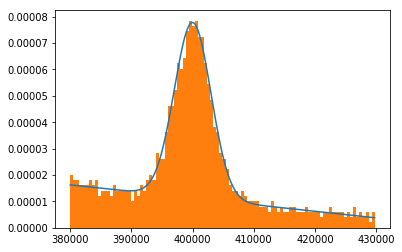

In [21]:
x=res.x
E.sort()
plt.plot(E, x[0]*fs(x)+(1-x[0])*fb(x));
plt.hist(E, bins=100, density=True);

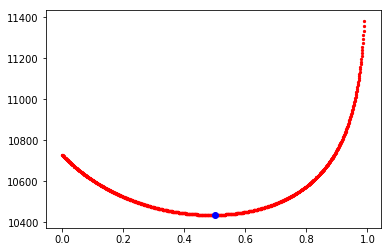

In [22]:
fss = np.linspace(0, .99, 1000)
xs = [[f, *res.x[1:4]] for f in fss]

for i in range(0,len(fss)):
    plt.scatter(fss[i], likelihood(xs[i]), c='r', s=5)
    
plt.scatter(res.x[0], likelihood(res.x), c='b');

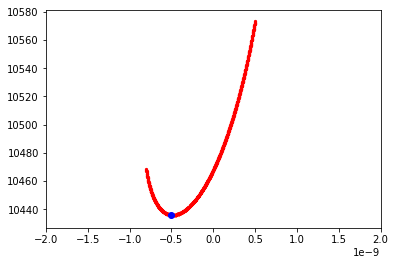

In [23]:
mss = np.linspace(-.8e-9, .5e-9, 1000)
xs = [[*res.x[0:3], m] for m in mss]

for i in range(0,len(fss)):
    plt.scatter(mss[i], likelihood(xs[i]), c='r', s=5)
plt.xlim([-2e-9, 2e-9,]);

plt.scatter(res.x[-1], likelihood(res.x), c='b');

In [24]:
# OTHER ALGORITHM SLSQ (inequality constraints incompatible, i don't know why)

bounds = Bounds([0, Emin, 0, -1e-10], [1, Emax, np.inf, 1e-10], keep_feasible=True)

x0     = np.array([0.5, 400e3, 1e3, 1e-11])

constraints=[{'type':'ineq','fun':fb_constr, 'jac':jac_b_constr}]

res = minimize(likelihood, x0,
               method = 'SLSQP',
               options={'disp':True},
               jac   = jac_lik,
               constraints=constraints,
               bounds=bounds)

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 10714.048131004236
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1


## GLOBAL MINIMIZATION
using diferential_evolution algorithm

In [26]:
def likelihood(x):
    f = x[0]
    p = f*fs(x) + (1-f)*fb(x)
    
    if (p>=0).all():
        return -np.log(p).sum()
    else:
        return np.inf

def jac_lik(x):
    f = x[0]
    p = f*fs(x) + (1-f)*fb(x)
    
    Ephs, sigs = jac_s(x)
    mb         = jac_b(x)
    
    fder   = -((fs(x)-fb(x))/p).sum()
    Ephder = -(f    *Ephs   /p).sum()
    sigder = -(f    *sigs   /p).sum()
    mder   = -((1-f)*mb     /p).sum()
    
    return np.array([fder, Ephder, sigder, mder])

def fs(x):
    f, Eph, sig,_ = x
    A, _ = quad(gauss, Emin, Emax, args=(Eph, sig))
    return (1/A)*gauss(E, Eph, sig)

def gauss(E, Eph, sig):
    return np.e**(-(E-Eph)**2/(2*sig**2))

def jac_s(x):
    f, Eph, sig,_ = x
    
    Ephder = fs(x)*(E-Eph)/sig**2
    sigder = fs(x)*(-1/sig + (E-Eph)**2/sig**3)
    
    return np.array([Ephder, sigder])
     
def fb(x):  
    f, Eph, sig, m = x
    #m=m*1e-9
    ct = c(m)
    return m*E + ct

def c(m):
    return (1-0.5*m*(Emax**2-Emin**2))/(Emax-Emin)

def jac_b(x):
    mder = E - 0.5*(Emax**2-Emin**2)/(Emax-Emin)
    return mder


bounds = ((0,1),(Emin, Emax),(0, Emax-Emin),(-1e-9, 1e-9))
x0     = np.array([0.5, 400e3, 1e3, 1e-10])

res = optimize.differential_evolution(likelihood, 
                                      bounds,
                                      disp=True)

differential_evolution step 1: f(x)= 10491.3
differential_evolution step 2: f(x)= 10464.8


In [27]:
res.x

array([ 5.41419371e-01,  3.99476887e+05,  2.54517218e+03, -1.88117569e-10])

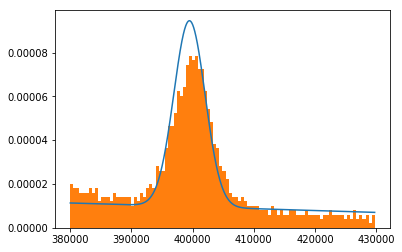

In [28]:
x=res.x
E.sort()
plt.plot(E, x[0]*fs(x)+(1-x[0])*fb(x));
plt.hist(E, bins=100, density=True);

## PROBABILITY FUNCTION METHOD

In [39]:
def likelihood(x):
    pr = p(x)
    return -np.log(pr).sum()

def jac_lik(x):
    A, Eph, sig, m = x
    
    pr = p(x)
    
    Ader   = -(gauss(E, Eph, sig)                     /pr).sum()
    Ephder = -(A*gauss(E, Eph, sig)*(E-Eph)/sig**2    /pr).sum()
    sigder = -(A*gauss(E, Eph, sig)*(E-Eph)**2/sig**3 /pr).sum()
    mder   = -(E - 0.5*(Emax**2-Emin**2)/(Emax-Emin)  /pr).sum()
    
    return np.array([Ader, Ephder, sigder, mder])

def p(x):
    A, Eph, sig, m = x
    ct = c(x)
    return A*np.e**(-(E-Eph)**2/(2*sig**2)) + m*E + ct

def c(x):
    A, Eph, sig, m = x
    I,_ = quad(gauss, Emin, Emax, args=(Eph, sig))
    
    return (1-A*I-0.5*m*(Emax**2-Emin**2))/(Emax-Emin)

def gauss(E, Eph, sig):
    return np.e**(-(E-Eph)**2/(2*sig**2))

##################################################
##################################################
##################################################
                  
def jac_p(x):
    A, Eph, sig, m = x
    
    Ader   = gauss(E, Eph, sig)
    Ephder = A*gauss(E, Eph, sig)*(E-Eph)/sig**2
    sigder = A*gauss(E, Eph, sig)*(E-Eph)**2/sig**3
    mder   = E - 0.5*(Emax**2-Emin**2)/(Emax-Emin)
    
    return np.array([Ader, Ephder, sigder, mder]).T

In [40]:
lb = [0     , Emin, 0     , -1]
ub = [np.inf, Emax, np.inf,  1]

bounds = Bounds(lb, ub, keep_feasible=True)
x0     = np.array([1e-4 , 400e3, 3e3, 1e-10])
#x0     =np.array([9.67530498e-05,  4.00000001e+05,  9.99997891e+02, -2.71698620e-10])

ub_b = np.inf*np.ones(len(E))
lb_b = np.zeros(len(E))

constraints = [NonlinearConstraint(p, lb_b, ub_b, jac=jac_p, hess=BFGS(), keep_feasible=True)]

res = minimize(likelihood, x0,
               method = 'trust-constr',
               options={'disp':True, 'verbose':3, 'maxiter':100, 'initial_tr_radius':1},
               jac   = jac_lik,
               hess  = BFGS(),
               constraints=constraints,
               bounds=bounds)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |barrier param|CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------------|-------|
|   1   |   1   |   0   | +8.8549e+03 | 1.00e+00 | 4.41e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   0   |
|   2   |   2   |   1   | +8.8503e+03 | 1.00e+00 | 4.68e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   3   |   3   |   5   | +8.8503e+03 | 1.00e+00 | 4.68e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   1   |
|   4   |   4   |   8   | +8.8464e+03 | 1.00e+00 | 4.90e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   5   |   5   |  11   | +8.8431e+03 | 1.00e+00 | 5.07e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   6   |   6   |  14   | +8.8408e+03 | 1.00e+00 | 5.17e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   7   |   7   |  17   | +8.8394e+03 | 1.00e+00 | 5.18e-01 | 0.00e+00 | 1.00e+00 |  1.00e-01   |   2   |
|   8   |   8   |  20   | +8.8390e+03 | 1.00e+

|  79   |  79   |  218  | +8.8390e+03 | 3.05e-05 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  80   |  80   |  221  | +8.8390e+03 | 1.53e-05 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  81   |  81   |  224  | +8.8390e+03 | 7.63e-06 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  82   |  82   |  227  | +8.8390e+03 | 3.81e-06 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  83   |  83   |  230  | +8.8390e+03 | 1.91e-06 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  84   |  84   |  233  | +8.8390e+03 | 9.54e-07 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  85   |  85   |  236  | +8.8390e+03 | 4.77e-07 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  86   |  86   |  239  | +8.8390e+03 | 2.38e-07 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  87   |  87   |  242  | +8.8390e+03 | 1.19e-07 | 5.09e-01 | 0.00e+00 | 1.00e+00 |  4.00e-03   |   2   |
|  88   |  88   |  244  | +8.8390e+03 | 5.96e-

In [41]:
res.x

array([ 1.01090738e-04,  4.00000001e+05,  2.99999963e+03, -4.52700357e-11])

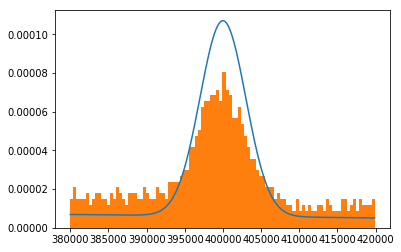

In [42]:
x=res.x
plt.plot(E, p(x));
plt.hist(E, bins=100,density=True);

/home/gonzalo/anaconda3/envs/IC-3.7-2018-10-20/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


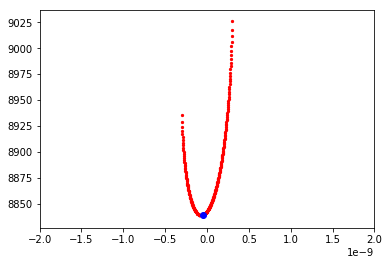

In [47]:
mss = np.linspace(-1e-9, 1e-9, 1000)
xs = [[*res.x[0:3], m] for m in mss]

for i in range(0,len(mss)):
    plt.scatter(mss[i], likelihood(xs[i]), c='r', s=5)
plt.xlim([-2e-9, 2e-9,]);

plt.scatter(res.x[-1], likelihood(res.x), c='b');